# Simple IMU Based Classification for QuadCopter Data

To keep it simple to start, we are going to be using four different flights in order to train a CNN/LSTM based model to classify between flights that are in theory circular (I guess nascar level circular) as well as flights that are figure 8 (lemniscate) shaped

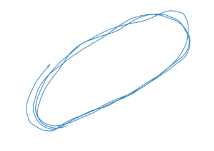
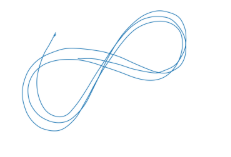

## Imports

In [37]:
import bagpy
from bagpy import bagreader

# Data processing
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt

# Visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Utilities
import os
import glob
import pickle

## Paths


In [38]:
RING_BAG_DIR = 'data/ring/ros'
LEMN_BAG_DIR = 'data/lemniscate/ros'

BASE_DIR = "/home/lucaseng/IMU-TFLM-ML"

OUTPUT_DIR = os.path.join(BASE_DIR, "output")
MODEL_SAVE_PATH = os.path.join(OUTPUT_DIR, "flight_classifier.keras")
TFLITE_FLOAT_PATH = os.path.join(OUTPUT_DIR, "model_float.tflite")
TFLITE_QUANT_PATH = os.path.join(OUTPUT_DIR, "model_quant.tflite")
SCALER_PATH = os.path.join(OUTPUT_DIR, "scaler.pkl")

os.makedirs(OUTPUT_DIR, exist_ok=True)

## Topics of the data

In [ ]:
ring_bag_files, lemn_bag_files = glob.glob(os.path.join(RING_BAG_DIR, "*.bag")), glob.glob(os.path.join(LEMN_BAG_DIR, "*.bag"))


sample_bag = ring_bag_files[0]  # or your specific path
print(f"Inspecting: {sample_bag}\n")

bag = bagreader(sample_bag)

# Show all topics with message counts and types
print("Available topics:")
print(bag.topic_table)


bag_files = glob.glob(os.path.join(LEMN_BAG_DIR, "*.bag"))

sample_bag = lemn_bag_files[0]  # or your specific path
print(f"Inspecting: {sample_bag}\n")

bag = bagreader(sample_bag)

# Show all topics with message counts and types
print("Available topics:")
print(bag.topic_table)


Inspecting: data/ring/ros/indoor_forward_5_davis_with_gt.bag

[INFO]  Successfully created the data folder data/ring/ros/indoor_forward_5_davis_with_gt.
Available topics:
                  Topics                      Types  Message Count   Frequency
0            /dvs/events        dvs_msgs/EventArray           4406   33.330981
1         /dvs/image_raw          sensor_msgs/Image           4787   33.155898
2               /dvs/imu            sensor_msgs/Imu         146701  999.119581
3  /groundtruth/odometry          nav_msgs/Odometry           9650  499.976636
4      /groundtruth/pose  geometry_msgs/PoseStamped           9650  499.976636
Inspecting: data/lemniscate/ros/indoor_forward_10_davis_with_gt.bag

[INFO]  Successfully created the data folder data/lemniscate/ros/indoor_forward_10_davis_with_gt.
Available topics:
                  Topics                      Types  Message Count   Frequency
0            /dvs/events        dvs_msgs/EventArray           2213   33.330981
1         /d

## Topics


In [39]:
TOPICS = {
    "imu": "/dvs/imu",                      # 1000Hz IMU data
    "ground_truth": "/groundtruth/pose",    # 500Hz pose (for labeling/validation)
    "odometry": "/groundtruth/odometry",    # 500Hz odom (has velocity too)
    # "events": "/dvs/events",              # DVS events - optional, complex to use
    # "image": "/dvs/image_raw",            # DVS frames - optional
}

## Signal Processing Hyperparameters


In [40]:
SAMPLING_RATE = 100
LOWPASS_CUTOFF = 30
LOWPASS_ORDER = 4

## Sequence / Windowing Hyperparameters

In [41]:
SEQUENCE_LENGTH = 100
SEQUENCE_STRIDE = 25

## Feature Configuration

In [42]:
# IMU features from /dvs/imu (sensor_msgs/Imu)
USE_IMU_ACCEL = True         # linear_acceleration: x, y, z (3 features)
USE_IMU_GYRO = True          # angular_velocity: x, y, z (3 features)
USE_IMU_ORIENTATION = False  # orientation quaternion - often noisy, skip for now

# Ground truth features (for training enrichment - may not have at inference!)
USE_POSITION = False         # Set True only if you'll have position at inference
USE_VELOCITY = False         # Can derive from odometry if needed

# For STM32 deployment, you'll likely only have IMU
# So keep features to what you'll have at inference time
NUM_FEATURES = (
    3 * USE_IMU_ACCEL +      # 3
    3 * USE_IMU_GYRO +       # 3
    4 * USE_IMU_ORIENTATION + # 0
    3 * USE_POSITION +        # 0
    3 * USE_VELOCITY          # 0
)
# = 6 features (accel + gyro)

print(f"Total features per timestep: {NUM_FEATURES}")

Total features per timestep: 6


## Model Architecture Hyperparameters

In [43]:
CNN_FILTERS = [16, 32]       # Good starting point
CNN_KERNEL_SIZE = 3
CNN_POOL_SIZE = 2

RNN_TYPE = "GRU"             # GRU recommended - better Cube.AI support than LSTM
RNN_UNITS = 32

DENSE_UNITS = 16
DROPOUT_RATE = 0.3

## Training Hyperparameters

In [44]:
BATCH_SIZE = 32
EPOCHS = 100
LEARNING_RATE = 1e-3
EARLY_STOPPING_PATIENCE = 15
LR_REDUCE_PATIENCE = 7
LR_REDUCE_FACTOR = 0.5
VALIDATION_SPLIT = 0.2
TEST_SPLIT = 0.1

## Quantization

In [45]:
QUANTIZATION_SAMPLES = 100

## STM32 Target

In [46]:
TARGET_MCU = "STM32F446RE"   # Adjust to your MCU
TARGET_FLASH_KB = 512
TARGET_RAM_KB = 128

## Data Extraction

Extracts the data and the ground truth for processing

In [47]:
def extract_imu_data(bag_path):
    """
    Extract IMU data from bag file.
    
    sensor_msgs/Imu contains:
    - header (timestamp)
    - orientation (quaternion)
    - angular_velocity (x, y, z)
    - linear_acceleration (x, y, z)
    """
    bag = bagreader(bag_path)
    
    # Extract IMU topic to CSV (bagpy does this automatically)
    imu_csv = bag.message_by_topic(TOPICS["imu"])
    imu_df = pd.read_csv(imu_csv)
    
    # Print columns to see structure
    print(f"IMU columns: {imu_df.columns.tolist()}")
    
    return imu_df


def extract_ground_truth(bag_path):
    """
    Extract ground truth pose for trajectory visualization.
    
    geometry_msgs/PoseStamped contains:
    - header (timestamp)
    - pose.position (x, y, z)
    - pose.orientation (quaternion)
    """
    bag = bagreader(bag_path)
    
    pose_csv = bag.message_by_topic(TOPICS["ground_truth"])
    pose_df = pd.read_csv(pose_csv)
    
    print(f"Pose columns: {pose_df.columns.tolist()}")
    
    return pose_df


# Test extraction on one bag
print("Testing data extraction...")
print("\n--- Oval bag ---")
test_imu = extract_imu_data(f'{RING_BAG_DIR}/indoor_forward_5_davis_with_gt.bag')
test_pose = extract_ground_truth(f'{RING_BAG_DIR}/indoor_forward_5_davis_with_gt.bag')

print(f"\nIMU shape: {test_imu.shape}")
print(f"IMU sample rate: {len(test_imu) / (test_imu['Time'].max() - test_imu['Time'].min()):.1f} Hz")
print(f"\nPose shape: {test_pose.shape}")

Testing data extraction...

--- Oval bag ---
[INFO]  Data folder data/ring/ros/indoor_forward_5_davis_with_gt already exists. Not creating.
IMU columns: ['Time', 'header.seq', 'header.stamp.secs', 'header.stamp.nsecs', 'header.frame_id', 'orientation.x', 'orientation.y', 'orientation.z', 'orientation.w', 'orientation_covariance_0', 'orientation_covariance_1', 'orientation_covariance_2', 'orientation_covariance_3', 'orientation_covariance_4', 'orientation_covariance_5', 'orientation_covariance_6', 'orientation_covariance_7', 'orientation_covariance_8', 'angular_velocity.x', 'angular_velocity.y', 'angular_velocity.z', 'angular_velocity_covariance_0', 'angular_velocity_covariance_1', 'angular_velocity_covariance_2', 'angular_velocity_covariance_3', 'angular_velocity_covariance_4', 'angular_velocity_covariance_5', 'angular_velocity_covariance_6', 'angular_velocity_covariance_7', 'angular_velocity_covariance_8', 'linear_acceleration.x', 'linear_acceleration.y', 'linear_acceleration.z', 'lin

## Data Preprocessing

In [48]:

def preprocess_imu(imu_df, target_rate=SAMPLING_RATE):
    """
    Preprocess IMU data:
    1. Extract relevant columns
    2. Low-pass filter (anti-aliasing)
    3. Downsample to target rate
    """
    
    # Get timestamps (convert to seconds from start)
    time = imu_df['Time'].values
    time = time - time[0]  # Start at 0
    
    # Extract accel and gyro
    # Column names depend on bagpy output - adjust if needed
    # Typical names: 'linear_acceleration.x' or 'linear_acceleration_x'
    
    # Try to find the right column names
    accel_cols = [c for c in imu_df.columns if 'linear_acceleration' in c.lower()]
    gyro_cols = [c for c in imu_df.columns if 'angular_velocity' in c.lower()]
    
    print(f"Accel columns: {accel_cols}")
    print(f"Gyro columns: {gyro_cols}")
    
    # Extract data (adjust column names based on your output)
    accel = imu_df[accel_cols].values  # Shape: (N, 3)
    gyro = imu_df[gyro_cols].values    # Shape: (N, 3)
    
    # Combine features
    features = np.hstack([accel, gyro])  # Shape: (N, 6)
    
    # Low-pass filter
    original_rate = len(time) / time[-1]
    nyquist = original_rate / 2
    normalized_cutoff = LOWPASS_CUTOFF / nyquist
    
    if normalized_cutoff < 1:
        b, a = butter(LOWPASS_ORDER, normalized_cutoff, btype='low')
        features_filtered = filtfilt(b, a, features, axis=0)
    else:
        features_filtered = features
        print("Warning: Cutoff frequency too high, skipping filter")
    
    # Downsample
    target_times = np.arange(0, time[-1], 1/target_rate)
    
    features_resampled = np.zeros((len(target_times), features.shape[1]))
    for i in range(features.shape[1]):
        interp_func = interp1d(time, features_filtered[:, i], 
                               kind='linear', fill_value='extrapolate')
        features_resampled[:, i] = interp_func(target_times)
    
    return features_resampled, target_times


# Test preprocessing
print("Testing preprocessing...")
features, times = preprocess_imu(test_imu)
print(f"Preprocessed shape: {features.shape}")
print(f"Duration: {times[-1]:.1f} seconds")
print(f"Effective rate: {len(times)/times[-1]:.1f} Hz")

Testing preprocessing...
Accel columns: ['linear_acceleration.x', 'linear_acceleration.y', 'linear_acceleration.z', 'linear_acceleration_covariance_0', 'linear_acceleration_covariance_1', 'linear_acceleration_covariance_2', 'linear_acceleration_covariance_3', 'linear_acceleration_covariance_4', 'linear_acceleration_covariance_5', 'linear_acceleration_covariance_6', 'linear_acceleration_covariance_7', 'linear_acceleration_covariance_8']
Gyro columns: ['angular_velocity.x', 'angular_velocity.y', 'angular_velocity.z', 'angular_velocity_covariance_0', 'angular_velocity_covariance_1', 'angular_velocity_covariance_2', 'angular_velocity_covariance_3', 'angular_velocity_covariance_4', 'angular_velocity_covariance_5', 'angular_velocity_covariance_6', 'angular_velocity_covariance_7', 'angular_velocity_covariance_8']
Preprocessed shape: (14684, 24)
Duration: 146.8 seconds
Effective rate: 100.0 Hz
